In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from sklearn.decomposition import PCA
rng = np.random.default_rng()

In [212]:
class Perceptron:
    def __init__(self, inputs) -> None:
        self.inputs = inputs

        # Inicialización de los pesos
        # Se agrega un elemento para representar el bias
        # y se resta 0.5 para que quede entre -0.5 y 0.5
        self.w = np.random.rand((inputs) + 1) - 0.5
    
    def eval(self, patron) :
        # Producto interno
        y = np.dot(patron, self.w)
   
        return y 

    def train(self, patron, alpha,err) :
        # Actualización de pesos
        self.w = self.w - (alpha * err) * patron
        return 

In [213]:
def generar_particiones(ds, n, p_test):
    # ds = np.genfromtxt(filename, delimiter=',')
    n_test = int(ds.shape[0] * p_test)
    n_train = ds.shape[0] - n_test
    M_test = np.zeros((n,n_test),dtype = int)
    M_train = np.zeros((n, n_train),dtype = int)

    for i in range(n):
        idx=np.random.choice(range(ds.shape[0]),ds.shape[0],replace = False)
        idx_test = idx[0:n_test]
        idx_train = idx[n_test:ds.shape[0]]
        M_test[i] = idx_test
        M_train[i] = idx_train
    
    return (idx, M_test, M_train)


In [214]:
def inicializar_asignacion_patrones(X,k):
    Patron_Centr = np.zeros(len(X))
       #k es la cantidad de centroides que tengo o neuronas
    for i in range(len(Patron_Centr)): #Recorro todos los datos
        Patron_Centr[i] = np.random.randint(0,k)
        #Asignacion alazar de los patrones a las neuronas
    return Patron_Centr

In [215]:
def kMeans(x, k):
    # k define la cantidad de grupos
    # se toman k grupos y se le asigna a cada patrón un grupo aleatorio
    # group_idx = np.repeat(range(k),np.ceil(x.shape[0]/k))[:x.shape[0]]
    group_idx = inicializar_asignacion_patrones(x,k)
    
        
    vec_reasig = np.zeros(x.shape[0])
    cant_it = 0
    means_vec = np.zeros((k, x.shape[1]))
    stdev_vec = np.zeros((k, x.shape[1]))

    # mientras se hayan hecho reasignaciones (sale cuando todos son verdaderos -> no hubo reasignaciones)
    while vec_reasig.all() != True:
        cant_it += 1
        
        # se calculan los centroides de cada grupo
        for i in range(k):
            group = x[group_idx == i]
            # si hay algo en el grupo
            if(group.shape[0] > 0):
                means_vec[i] =  np.mean(group, axis = 0)
                # if(group.shape[0] > 1):
                #     stdev_vec[i] = np.std(group, axis = 0)

        
        # por cada patron
        for i, pattern in enumerate(x):
            dist_vec = []
            for i_group in range(k):
                # vector distancias entre el patron y los centroides
                dist_vec.append(np.linalg.norm(pattern - means_vec[i_group]))
            # índice del centroide que tiene menor distancia
            idx_min = np.argmin(dist_vec)
            # reasignación de grupo si es necesario
            if (group_idx[i] != idx_min):
                vec_reasig[i] == False
                group_idx[i] = idx_min
            # si no hay reasignación se pone en verdadero
            else:
                vec_reasig[i] = True
    
    for i in range(k):
        group = x[group_idx == i]
        # si hay algo en el grupo
        if(group.shape[0] > 1):
            stdev_vec[i] = np.std(group, axis = 0)
        else:
            stdev_vec[i] =1
    
    print(np.histogram(group_idx,range(k+1)))
            
    return group_idx, stdev_vec, means_vec, cant_it

In [216]:
def ds_regrecion(ds):
    x_r=[]
    y_r=[]
    for i in range (ds.shape[0]-5):
        x_r.append(ds[i:i+5])
        y_r.append(ds[i+5])
    return (x_r,y_r)


In [217]:
def shuffle(X,Yd):
    print(X.shape[0])
    idx=np.arange(X.shape[0])
    np.random.shuffle(idx)
    X_=[]
    Yd_=np.zeros(Yd.shape[0])
    for i,idn in enumerate(idx):
        X_.append(X[idn])
        Yd_[i] = Yd[idn]
    X_=np.array(X_)
    return (X_,Yd_,idx)
    

In [218]:
ds = np.genfromtxt('gtp2datos/merval.csv', delimiter=',')
X,Yd=ds_regrecion(ds)
X=np.array(X)
Yd=np.array(Yd).reshape((-1,1))
X,Yd,idx = shuffle(X,Yd)
k = 4    # cantidad de grupos / RBF
# [puede ser que queden grupos vacíos?]
 

473


In [219]:
#perceptrón
# Parámetros de entrenamiento
NEpoch = 1000        # Cantidad de épocas máximas (anterior 2000)
errorThr = 0.02         # Umbral de error para finalizar (anterior 0.005)
lr = 0.01                # Tasa de aprendizaje (anterior 8E-3)
varianza=np.average(Yd)

In [220]:
errorRatePerEpoch = []
MMSEPerEpoch = []

#Entrenamiento
group_idx, stdev_vec, centroides, cant_it = kMeans(X,k)
print(centroides)

# np.random.seed(111)
#Por si tengo mas de una neurona en la capa de salida
# if(np.ndim(Yd)>1):
#     #shape[1] da la cantidad de columnas
#     w = np.random.rand(Yd.shape[1],k+1) - 0.5
# else:
#     w = np.random.rand(1,k+1) - 0.5 
# print(w)
perceptron = Perceptron(k)

print('pesos w del perceptron -->',perceptron.w)
# w = np.random.rand(X.shape[1]+1) - 0.5
error_norm = 9999
mmse_per_epoch=[]
#tol = 0.00001
tol = 0.01
for epoc in range(NEpoch):
    Y = []
    Error_i = []
    for i in range(X.shape[0]): #recorremos datos
        Y_rbf = []
        for j in range(k): #Un patron de entrada te genera varias salidas en la capa oculta | gausianitas
            # gauss = f_gaussian(X[i], centroides, varianza)
            gauss = np.exp(-1/(2*varianza**2)*((np.linalg.norm(X[i]-centroides[j]))**2))
            Y_rbf.append(gauss)
        
        Y_rbf = np.hstack((-1,Y_rbf)) #Agregamos el sesgo para la capa de salida
            
        #Salida del percetron - Depende del W voy a tener una o mas salidas [por fila tiene los pesos de la neuronas de salida]
        y = perceptron.eval(Y_rbf) #Acordate que multiplica y suma por elemento [si es una martiz de 2x3 tengo 2 salidas y]
        Y.append(y)
        
        error = y - Yd[i]
        Error_i.append(error)
        #print("Salida: ", y)
        #print("Deseada: ",Yd[i])
        
        #Actualizacion de pesos W
        perceptron.train(Y_rbf,lr,error)

        # for j in range(k):
        #     m=0 #El vector de pesos estaba dentro de otro array, por tomo la pos 0
        #     perceptron.w[j] = perceptron.w[j] - lr*error*Y_rbf[j]
    
    
    # error_norm = np.linalg.norm(Y-Yd)
    error_norm = np.linalg.norm(Error_i)
    mmse_per_epoch.append(error_norm)        
    if(error_norm<errorThr):
        print("Epoca: ", epoc, "Error: ", error_norm)
        break
    # error = RBF_TEST_Merval(X,Yd,k,w,centroides,varianza)
    print("Epoca: ", epoc, "Error: ", error_norm)
    # aciertos = 0
y_final = Y


(array([125,  98,  44, 206], dtype=int64), array([0, 1, 2, 3, 4]))
[[762.90066225 765.50993377 768.08609272 770.42384106 772.72847682]
 [571.08333333 572.06944444 573.04166667 574.25       575.48611111]
 [499.19354839 501.19354839 503.67741935 506.70967742 509.06451613]
 [375.456621   376.57077626 377.67579909 378.73059361 379.79908676]]
pesos w del perceptron --> [-0.35404332 -0.30564405  0.01085923 -0.43177311  0.42872306]
Epoca:  0 Error:  4272.896462420514
Epoca:  1 Error:  2218.422631180083
Epoca:  2 Error:  1719.7423405645075
Epoca:  3 Error:  1526.7983172068098
Epoca:  4 Error:  1418.0082133194005
Epoca:  5 Error:  1339.264361555828
Epoca:  6 Error:  1277.2974766341306
Epoca:  7 Error:  1227.6319378583194
Epoca:  8 Error:  1187.806987400001
Epoca:  9 Error:  1155.9882642081698
Epoca:  10 Error:  1130.670026905161
Epoca:  11 Error:  1110.5962327693449
Epoca:  12 Error:  1094.7247994753004
Epoca:  13 Error:  1082.1998289805592
Epoca:  14 Error:  1072.3254857280622
Epoca:  15 Error

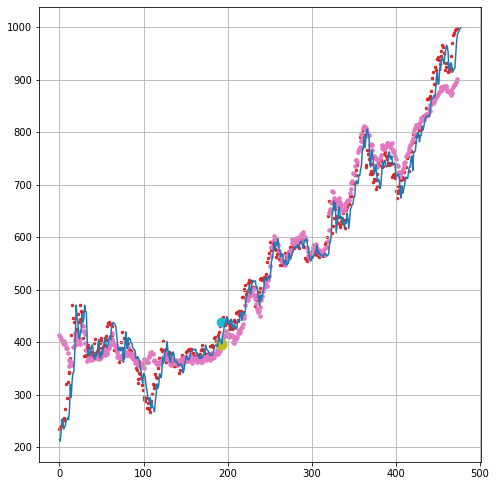

In [221]:
# Gráfica de la tasa de error por época junto con el MSE promedio por épo

fig1, fig1_ax = plt.subplots(figsize=(7, 7), tight_layout=True)
fig1.suptitle("")
fig1_ax.set_xlabel('')
fig1_ax.grid()
fig1_ax.set_ylabel('')

plt.plot(ds)
lalencios=np.arange(5,478,1)
plt.scatter(idx,Yd, c='C3', s=25, marker='.')
plt.scatter(idx,y_final, c='C6', s=50, marker='.')

plt.scatter(idx[400],Yd[400], c='C9', s=300, marker='.')
plt.scatter(idx[400],y_final[400], c='C8', s=500, marker='.')





plt.show()